In [1]:
"""
1D Euler Equation: Conservative Form
    Spatial: WENO-5 Roe's Riemann Solver, HLLC, Rusanov
    Temporal: RK3
"""
import sys
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse
import numpy.linalg
from tqdm.notebook import tqdm
np.set_printoptions(threshold=sys.maxsize, linewidth=np.inf)


In [2]:
gamma = 1.4 # specific gas ratio

# Sod's Riemann problem
# Left side
rhoL = 1.0
uL = 0.0
pL = 1.0
eL = pL/(rhoL*(gamma-1)) + 0.5*uL**2
qL = np.array([rhoL, rhoL*uL, rhoL*eL])
# Right side
rhoR = 0.125
uR = 0.0
pR = 0.1
eR = pR/(rhoR*(gamma-1)) + 0.5*uR**2
qR = np.array([rhoR, rhoR*uR, rhoR*eR])

In [3]:
def InitialCondition(x):
    rho = (x<=0.5)*rhoL + (x>0.5)*rhoR
    u = (x<=0.5)*uL + (x>0.5)*uR
    e = (x<=0.5)*eL + (x>0.5)*eR

    return np.vstack([rho, rho*u, rho*e])

In [4]:
def BoundaryConditionDir(u):
    u[:,0:3] = qL[:,np.newaxis]*np.array([[6,4,2]]) - u[:,3][:,np.newaxis]*np.array([[5,3,1]])
    u[:,-3:] = qR[:,np.newaxis]*np.array([[2,4,6]]) - u[:,-4][:,np.newaxis]*np.array([[1,3,5]])

    # u[:,0:3] = qL[:,np.newaxis]*np.array([[1,1,1]])
    # u[:,-3:] = qR[:,np.newaxis]*np.array([[1,1,1]])

In [5]:
def WENOSmoothCoeffL(v1,v2,v3,v4,v5):
    eps = 1e-6
    dL = np.array([0.2, 0.5, 0.3])[:,np.newaxis,np.newaxis]
    b = np.array([
        (13.0/12.0)*(v1-2.0*v2+v3)**2 + 0.25*(v1-4.0*v2+3.0*v3)**2,
        (13.0/12.0)*(v2-2.0*v3+v4)**2 + 0.25*(v2-v4)**2,
        (13.0/12.0)*(v3-2.0*v4+v5)**2 + 0.25*(3.0*v3-4.0*v4+v5)**2
    ])
    a = dL/(b+eps)**2 # WENO-5
    a = dL*(1+(np.abs(b[2,:,:]-b[0,:,:])/(b+eps))**2)  # WENO-Z
    return a/np.sum(a, axis=0)

def WENOSmoothCoeffR(v1,v2,v3,v4,v5):
    eps = 1e-6
    dR = np.array([0.3, 0.5, 0.2])[:,np.newaxis,np.newaxis]
    b = np.array([
        (13.0/12.0)*(v1-2.0*v2+v3)**2 + 0.25*(v1-4.0*v2+3.0*v3)**2,
        (13.0/12.0)*(v2-2.0*v3+v4)**2 + 0.25*(v2-v4)**2,
        (13.0/12.0)*(v3-2.0*v4+v5)**2 + 0.25*(3.0*v3-4.0*v4+v5)**2
    ])
    a = dR/(b+eps)**2
    a = dR*(1+(np.abs(b[2,:,:]-b[0,:,:])/(b+eps))**2)
    return a/np.sum(a, axis=0)

In [6]:
def WENOfromLeft(v1,v2,v3,v4,v5):
    # if the flow come from left
    # the velocity value at i+1/2
    # i-2, i-1, i | i+1, i+2
    wL = WENOSmoothCoeffL(v1,v2,v3,v4,v5)
    uL = (
        wL[0,:,:]*(v1/3.0 - 7.0/6.0*v2 + 11.0/6.0*v3) +
        wL[1,:,:]*(-v2/6.0 + 5.0/6.0*v3 + v4/3.0) +
        wL[2,:,:]*(v3/3.0 + 5.0/6.0*v4 - v5/6.0)
    )
    return uL

def WENOfromRight(v1,v2,v3,v4,v5):
    # if the flow come from left
    # the velocity value at i-1/2
    # i-2, i-1 | i , i+1, i+2
    wR = WENOSmoothCoeffR(v1,v2,v3,v4,v5)
    uR = (
        wR[0,:,:]*(-1.0/6.0*v1 + 5.0/6.0*v2 + 1.0/3.0*v3) +
        wR[1,:,:]*(v2/3.0 + 5.0/6.0*v3 - v4/6.0) +
        wR[2,:,:]*(11.0*v3/6.0 - 7.0/6.0*v4 +1.0/3.0*v5)
    )
    return uR

In [7]:
def LeftRightFluxes(q):
    qL = WENOfromLeft(q[:,0:-5], q[:,1:-4], q[:,2:-3], q[:,3:-2], q[:,4:-1])
    qR = WENOfromRight(q[:,1:-4], q[:,2:-3], q[:,3:-2], q[:,4:-1], q[:,5:])

    rhL = qL[0,:]
    uuL = qL[1,:]/rhL
    eeL = qL[2,:]/rhL
    ppL = rhL*(gamma-1)*(eeL-0.5*uuL**2)
    hhL = eeL+ppL/rhL
    aaL = np.sqrt(np.abs(gamma*ppL/rhL))
    FL = np.vstack([
        qL[1,:], rhL*uuL**2+ppL, rhL*uuL*hhL
    ])

    rhR = qR[0,:]
    uuR = qR[1,:]/rhR
    eeR = qR[2,:]/rhR
    ppR = rhR*(gamma-1)*(eeR-0.5*uuR**2)
    hhR = eeR+ppR/rhR
    aaR = np.sqrt(np.abs(gamma*ppR/rhR))
    FR = np.vstack([
        qR[1,:], rhR*uuR**2+ppR, rhR*uuR*hhR
    ])

    return qL,qR,rhL,uuL,eeL,ppL,hhL,aaL,FL,rhR,uuR,eeR,ppR,hhR,aaR,FR

In [8]:
def RoeAvg(rhL,rhR,uuL,uuR,hhL,hhR):
    sRHL = np.sqrt(rhL)
    sRHR = np.sqrt(rhR)
    sRHLpsRHR = sRHL+sRHR

    uRoeAvg = (uuL*sRHL+uuR*sRHR)/sRHLpsRHR
    hRoeAvg = (hhL*sRHL+hhR*sRHR)/sRHLpsRHR
    aRoeAvg = np.sqrt((gamma-1)*(hRoeAvg-0.5*uRoeAvg**2))
    return uRoeAvg, hRoeAvg, aRoeAvg

In [9]:
def RoeFlux(q, BCFun):
    qL,qR,rhL,uuL,eeL,ppL,hhL,aaL,FL,rhR,uuR,eeR,ppR,hhR,aaR,FR = LeftRightFluxes(q)

    uRoeAvg, hRoeAvg, aRoeAvg = RoeAvg(rhL,rhR,uuL,uuR,hhL,hhR)
    p2RoeAvg = 0.5*(gamma-1)*uRoeAvg**2
    betaRoeAvg = 1/(2*aRoeAvg**2)
    zeros = np.zeros(uRoeAvg.shape)
    ones = np.ones(uRoeAvg.shape)

    R = np.array([
        [ones, betaRoeAvg, betaRoeAvg],
        [uRoeAvg, betaRoeAvg*(uRoeAvg+aRoeAvg), betaRoeAvg*(uRoeAvg-aRoeAvg)],
        [p2RoeAvg/(gamma-1), betaRoeAvg*(hRoeAvg+uRoeAvg*aRoeAvg), betaRoeAvg*(hRoeAvg-uRoeAvg*aRoeAvg)]
    ])

    L = np.array([
        [1-p2RoeAvg/aRoeAvg**2, (gamma-1)*uRoeAvg/aRoeAvg**2, -(gamma-1)/aRoeAvg**2],
        [p2RoeAvg-uRoeAvg*aRoeAvg, aRoeAvg-(gamma-1)*uRoeAvg, gamma-ones],
        [p2RoeAvg+uRoeAvg*aRoeAvg, -aRoeAvg-(gamma-1)*uRoeAvg, gamma-ones]
    ])

    D = np.abs(np.array([
        [uRoeAvg, zeros, zeros], 
        [zeros, uRoeAvg+aRoeAvg, zeros], 
        [zeros, zeros, uRoeAvg-aRoeAvg]
    ])) # NOTE: here is an absolute value!!!


    return 0.5*(FR+FL) - 0.5*np.einsum('ijk,jmk,mnk,nk->ik',R,D,L,(qR-qL))


The HLLC flux condition should be 
$$
F_{i+\frac{1}{2}} = 
\begin{dcases}
F^L, & \quad \text{if } S_L \geq 0 \\
F^R, & \quad \text{if } S_R \leq 0 \\
\frac{S_*(S_L \textcolor{red}{q_L} F^L)+S_L P_{LR}D_*}{S_L-S_*}, & \quad \text{if } S_L \leq 0 \text{ and } S_* \geq 0 \\
\frac{S_*(S_R \textcolor{red}{q_R} F^R)+S_R P_{LR}D_*}{S_R-S_*}, & \quad \text{if } S_R \geq 0 \text{ and } S_* \leq 0
\end{dcases}
$$

In [10]:
def HLLCFlux(q, BCFun):
    qL,qR,rhL,uuL,eeL,ppL,hhL,aaL,FL,rhR,uuR,eeR,ppR,hhR,aaR,FR = LeftRightFluxes(q)

    SL = np.minimum(uuL,uuR) - np.maximum(aaL,aaR)
    SR = np.minimum(uuL,uuR) + np.maximum(aaL,aaR)
    SStar = (ppR-ppL + rhL*uuL*(SL-uuL) - rhR*uuR*(SR-uuR))/(
        rhL*(SL-uuL) - rhR*(SR-uuR)
    )
    PLR = 0.5*(ppL+ppR + rhL*(SL-uuL)*(SStar-uuL) + rhR*(SR-uuR)*(SStar-uuR))

    D = np.vstack((
        np.zeros(rhL.shape), np.ones(rhL.shape), SStar
    ))

    FPL = (SStar*(SL*qL-FL) + SL*PLR*D)/(SL-SStar) # here should be qL
    FPR = (SStar*(SR*qR-FR) + SR*PLR*D)/(SR-SStar) # here should be qR

    # there is some bulean overlaping!!!
    flux = FL * 0
    flux[:,(SR>0)&(SStar<=0)] = FPR[:,(SR>0)&(SStar<=0)]
    flux[:,(SL<0)&(SStar>=0)] = FPL[:,(SL<0)&(SStar>=0)]
    flux[:,(SR<=0)] = FR[:,(SR<=0)]
    flux[:,SL>=0] = FL[:,SL>=0]


    return flux
    


In [11]:
def RusanovFlux(q, BCFun):
    qL,qR,rhL,uuL,eeL,ppL,hhL,aaL,FL,rhR,uuR,eeR,ppR,hhR,aaR,FR = LeftRightFluxes(q)

    uRoeAvg, hRoeAvg, aRoeAvg = RoeAvg(rhL,rhR,uuL,uuR,hhL,hhR)

    waveSpeed = np.amax(np.vstack((
        uRoeAvg, np.abs(uRoeAvg+aRoeAvg), np.abs(uRoeAvg-aRoeAvg)
    )))
    return 0.5*(FL+FR) - 0.5*waveSpeed*(qR-qL)

In [12]:
def RK3WENORoeRiemann(uOrig, dX, dT, BCfun):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    flux = RoeFlux(uOrig, BoundaryConditionDir)
    uOne[:,3:-3] = uOrig[:,3:-3] - dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uOne)

    # Second Intermediate
    flux = RoeFlux(uOne, BoundaryConditionDir)
    uTwo[:,3:-3] = 3./4. * uOrig[:,3:-3] + 1./4. * uOne[:,3:-3] - 0.25 * dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uTwo)

    # Final
    flux = RoeFlux(uTwo, BoundaryConditionDir)
    uNow[:,3:-3] = 1./3. * uOrig[:,3:-3] + 2./3. * uTwo[:,3:-3] - 2.0/3.0 * dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uNow)
    return uNow

In [13]:
def RK3WENOHLLCRiemann(uOrig, dX, dT, BCfun):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    flux = HLLCFlux(uOrig, BoundaryConditionDir)
    uOne[:,3:-3] = uOrig[:,3:-3] - dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uOne)

    # Second Intermediate
    flux = HLLCFlux(uOne, BoundaryConditionDir)
    uTwo[:,3:-3] = 3./4. * uOrig[:,3:-3] + 1./4. * uOne[:,3:-3] - 0.25 * dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uTwo)

    # Final
    flux = HLLCFlux(uTwo, BoundaryConditionDir)
    uNow[:,3:-3] = 1./3. * uOrig[:,3:-3] + 2./3. * uTwo[:,3:-3] - 2.0/3.0 * dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uNow)
    return uNow

In [14]:
def RK3WENORusanovRiemann(uOrig, dX, dT, BCfun):
    # NOTE: the journal is incorrect please have a look on
    # Proposition 3.2 in TOTAL VARIATION DIMINISHING RUNGE-KUTTA SCHEMES
    uOne = uOrig*np.nan
    uTwo = uOrig*np.nan
    uNow = uOrig*np.nan
    # First Intermediate
    flux = RusanovFlux(uOrig, BoundaryConditionDir)
    uOne[:,3:-3] = uOrig[:,3:-3] - dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uOne)

    # Second Intermediate
    flux = RusanovFlux(uOne, BoundaryConditionDir)
    uTwo[:,3:-3] = 3./4. * uOrig[:,3:-3] + 1./4. * uOne[:,3:-3] - 0.25 * dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uTwo)

    # Final
    flux = RusanovFlux(uTwo, BoundaryConditionDir)
    uNow[:,3:-3] = 1./3. * uOrig[:,3:-3] + 2./3. * uTwo[:,3:-3] - 2.0/3.0 * dT/dX * (
        flux[:,1:] - flux[:,:-1]
    )
    BCfun(uNow)
    return uNow

In [15]:
# Domain   0...1
xMin, xMax = (0., 1.)
numCell = 256
xNode = np.linspace(xMin, xMax, num=numCell+1)
xCen = (xNode[:-1]+xNode[1:])/2
deltaX = xCen[1] - xCen[0]
xCwG = np.array([
    *(xCen[0:3]-3*deltaX), *xCen, *(xCen[-3:]+3*deltaX)
])

# temporal
tStart = 0.0
tEnd = 0.2
deltaT = 1e-4
numStep = np.rint((tEnd-tStart)/deltaT).astype(int)

# how many state to save (w/o initial condition)
numSaveState = 10
timeState = np.linspace(tStart,tEnd,numSaveState+1,endpoint=True)
# timeState = deltaT*np.arange(numSaveState+1)


In [16]:
uInitial = InitialCondition(xCwG)
BoundaryConditionDir(uInitial)

States = np.zeros((numSaveState+1, *uInitial.shape))*np.nan

uOriginal = uInitial*1.0
States[0, :,:] = uOriginal

tNow = tStart

In [17]:

for iStep in tqdm(range(numStep)):
    tNow += deltaT
    uOriginal = RK3WENORusanovRiemann(uOriginal, deltaX, deltaT, BoundaryConditionDir)
    
    if np.min(np.abs(tNow-timeState)) < deltaT*0.2:
        States[np.argmin(np.abs(tNow-timeState)), :,:] = uOriginal

  0%|          | 0/2000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Time Evolution of pressure')

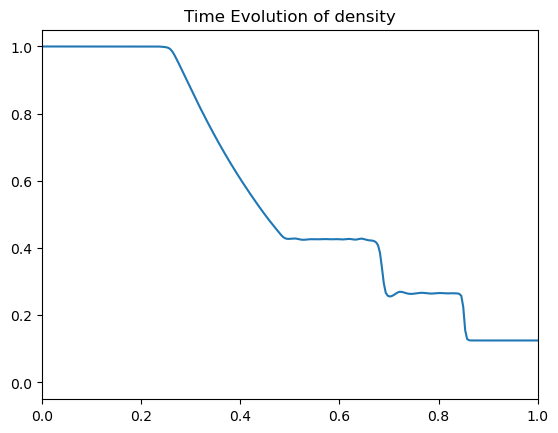

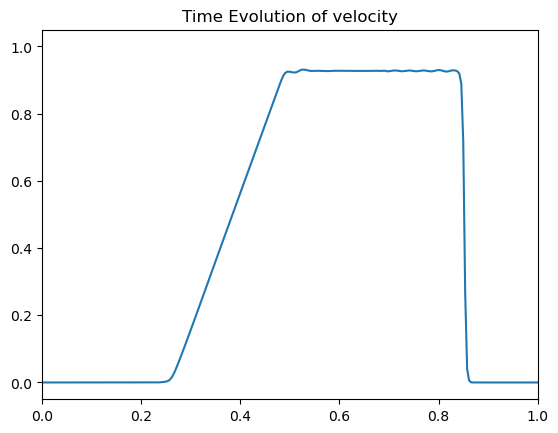

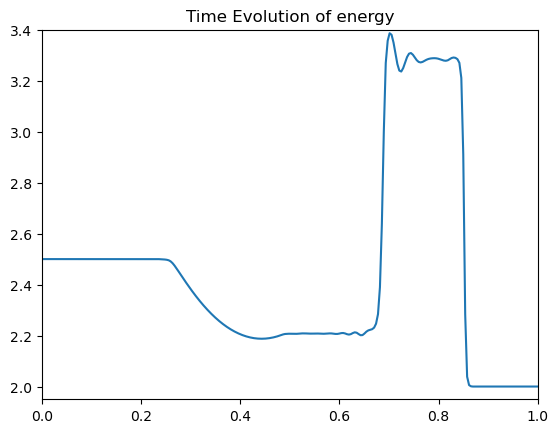

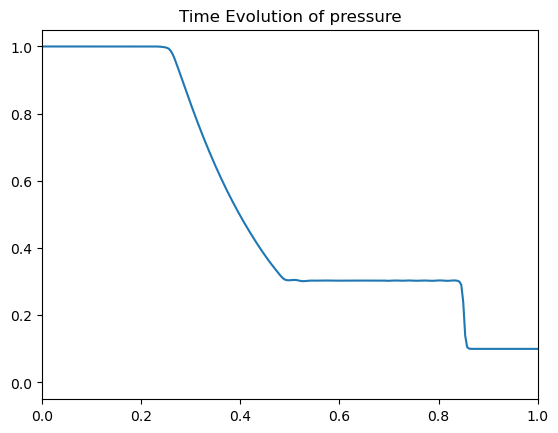

In [18]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()

for i in [numSaveState]:
    rho = States[i,0,:]
    vel = States[i,1,:]/rho
    eng = States[i,2,:]/rho
    pre = rho*(gamma-1)*(eng-0.5*vel**2)

    ax1.plot(xCwG, rho, linestyle="-")
    ax2.plot(xCwG, vel, linestyle="-")
    ax3.plot(xCwG, eng, linestyle="-")
    ax4.plot(xCwG, pre, linestyle="-") 

ax1.set_xlim([0,1])
ax2.set_xlim([0,1])
ax3.set_xlim([0,1])
ax4.set_xlim([0,1])

ax1.set_ylim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax3.set_ylim([1.95,3.4])
ax4.set_ylim([-0.05,1.05])

ax1.set_title("Time Evolution of density")
ax2.set_title("Time Evolution of velocity")
ax3.set_title("Time Evolution of energy")
ax4.set_title("Time Evolution of pressure")